<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_rendah2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f6ea212d2e0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_bawah_ii.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


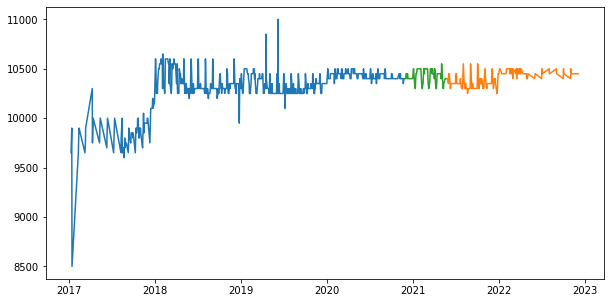

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [11]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [12]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_rendah2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 215ms/step - loss: 0.5206 - mae: 0.7205 - mape: 93.3483 - val_loss: 0.1946 - val_mae: 0.3936 - val_mape: 11455320.0000
Epoch 2/30
44/44 [==============================] - 9s 194ms/step - loss: 0.3697 - mae: 0.6069 - mape: 78.6295 - val_loss: 0.1267 - val_mae: 0.3126 - val_mape: 23015060.0000
Epoch 3/30
44/44 [==============================] - 9s 193ms/step - loss: 0.2580 - mae: 0.5069 - mape: 65.6584 - val_loss: 0.0865 - val_mae: 0.2601 - val_mape: 33039838.0000
Epoch 4/30
44/44 [==============================] - 9s 195ms/step - loss: 0.1760 - mae: 0.4185 - mape: 54.2068 - val_loss: 0.0650 - val_mae: 0.2132 - val_mape: 41991196.0000
Epoch 5/30
44/44 [==============================] - 10s 232ms/step - loss: 0.1171 - mae: 0.3411 - mape: 44.1800 - val_loss: 0.0575 - val_mae: 0.1980 - val_mape: 49628044.0000
Epoch 6/30
44/44 [==============================] - 9s 195ms/step - loss: 0.0765 - mae: 0.2755 - mape: 35.6705 - val_loss: 0.059

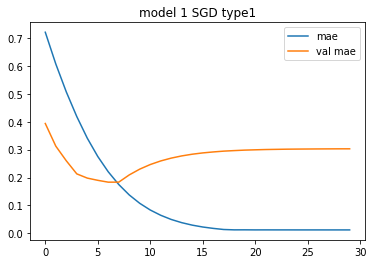

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
67.91613 0.655224 78.59638104443009


,date,actual,prediction
0,2021-05-20,10400,10427.487305
1,2021-05-21,10400,10426.831055
2,2021-05-24,10400,10427.418945
3,2021-05-25,10400,10426.738281
4,2021-05-27,10400,10427.339844
...,...,...,...
229,2022-11-02,10500,10428.562500
230,2022-11-03,10450,10428.850586
231,2022-11-04,10450,10428.545898
232,2022-12-01,10450,10428.920898


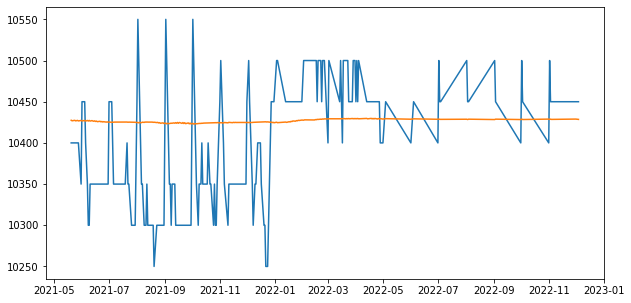

In [ ]:
prediction = forecast_predict(model, test_beras_rendah2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras_rendah2 = pd.DataFrame()
data_new_beras_rendah2['date'] = y_test
data_new_beras_rendah2['actual'] = x_test
data_new_beras_rendah2['prediction'] = data_result
data_new_beras_rendah2.to_csv('beras_rendah2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras_rendah2.date, data_new_beras_rendah2.actual)
plt.plot(data_new_beras_rendah2.date, data_new_beras_rendah2.prediction)
data_new_beras_rendah2

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0016 - mae: 0.0323 - mape: 4.3096 - val_loss: 0.1319 - val_mae: 0.2949 - val_mape: 81148336.0000
Epoch 2/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0016 - mae: 0.0321 - mape: 4.2706 - val_loss: 0.1310 - val_mae: 0.2936 - val_mape: 80968792.0000
Epoch 3/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0016 - mae: 0.0316 - mape: 4.2018 - val_loss: 0.1319 - val_mae: 0.2949 - val_mape: 81142168.0000
Epoch 4/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0016 - mae: 0.0318 - mape: 4.2349 - val_loss: 0.1314 - val_mae: 0.2942 - val_mape: 81053808.0000
Epoch 5/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0016 - mae: 0.0319 - mape: 4.2513 - val_loss: 0.1316 - val_mae: 0.2945 - val_mape: 81088320.0000
Epoch 6/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0016 - mae: 0.0319 - mape: 4.2477 - val_loss: 0

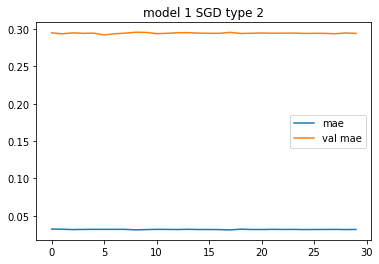

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
62.438717 0.60070896 70.94711870360733


,date,actual,prediction
0,2021-05-20,10400,10427.487305
1,2021-05-21,10400,10426.831055
2,2021-05-24,10400,10427.418945
3,2021-05-25,10400,10426.738281
4,2021-05-27,10400,10427.339844
...,...,...,...
229,2022-11-02,10500,10428.562500
230,2022-11-03,10450,10428.850586
231,2022-11-04,10450,10428.545898
232,2022-12-01,10450,10428.920898


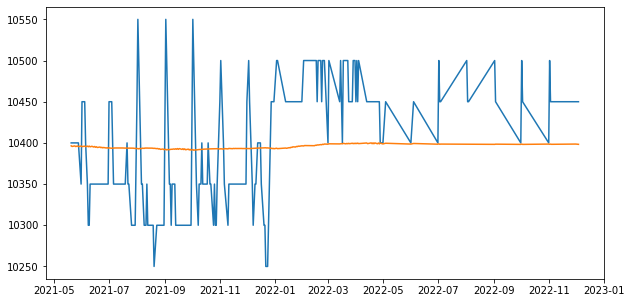

In [ ]:
win_size1 = 60
test_beras_rendah2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_rendah2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_rendah2_1 = pd.DataFrame()
data_new_beras_rendah2_1['actual'] = x_test
data_new_beras_rendah2_1['prediction'] = data_result_1
data_new_beras_rendah2_1.to_csv('beras_rendah2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah2_1.actual)
plt.plot(y_test, data_new_beras_rendah2_1.prediction)
data_new_beras_rendah2

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0012 - mae: 0.0259 - mape: 3.5051 - val_loss: 0.1290 - val_mae: 0.2908 - val_mape: 80578104.0000
Epoch 2/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0012 - mae: 0.0265 - mape: 3.5649 - val_loss: 0.1276 - val_mae: 0.2887 - val_mape: 80288464.0000
Epoch 3/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0012 - mae: 0.0269 - mape: 3.6169 - val_loss: 0.1269 - val_mae: 0.2876 - val_mape: 80144480.0000
Epoch 4/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0012 - mae: 0.0270 - mape: 3.6245 - val_loss: 0.1267 - val_mae: 0.2873 - val_mape: 80102656.0000
Epoch 5/30
84/84 [==============================] - 12s 145ms/step - loss: 0.0012 - mae: 0.0271 - mape: 3.6341 - val_loss: 0.1264 - val_mae: 0.2869 - val_mape: 80040504.0000
Epoch 6/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0012 - mae: 0.0272 - mape: 3.6428 - val_loss: 0.1265 

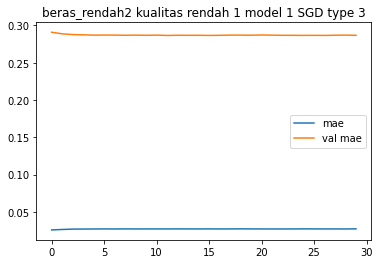

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras_rendah2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
62.905815 0.60403657 73.05270865743104


,actual,prediction
0,10400,10376.777344
1,10400,10376.002930
2,10400,10376.695312
3,10400,10375.883789
4,10400,10376.604492
...,...,...
229,10500,10378.637695
230,10450,10378.885742
231,10450,10378.612305
232,10450,10378.975586


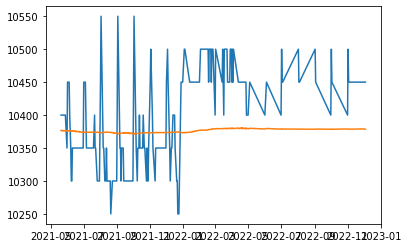

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_rendah2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_rendah2_2 = pd.DataFrame()
# data_new_beras_rendah21['date'] = date_test
data_new_beras_rendah2_2['actual'] = x_test
data_new_beras_rendah2_2['prediction'] = data_result_2
data_new_beras_rendah2_2.to_csv('beras_rendah2_model1_sgd_type3')

plt.plot(y_test, data_new_beras_rendah2_2.actual)
plt.plot(y_test, data_new_beras_rendah2_2.prediction)
data_new_beras_rendah2_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_3 (Dense)             (None, 64)                1344      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 13s 212ms/step - loss: 0.6362 - mae: 0.7965 - mape: 103.2021 - val_loss: 0.2492 - val_mae: 0.4465 - val_mape: 3926676.0000
Epoch 2/30
44/44 [==============================] - 9s 195ms/step - loss: 0.4711 - mae: 0.6854 - mape: 88.8169 - val_loss: 0.1838 - val_mae: 0.3821 - val_mape: 13130713.0000
Epoch 3/30
44/44 [==============================] - 9s 195ms/step - loss: 0.2874 - mae: 0.5316 - mape: 68.8639 - val_loss: 0.0825 - val_mae: 0.2535 - val_mape: 34738728.0000
Epoch 4/30
44/44 [==============================] - 9s 193ms/step - loss: 0.0514 - mae: 0.1954 - mape: 25.2599 - val_loss: 0.0895 - val_mae: 0.2203 - val_mape: 71230880.0000
Epoch 5/30
44/44 [==============================] - 8s 191ms/step - loss: 3.2613e-04 - mae: 0.0153 - mape: 1.9829 - val_loss: 0.0963 - val_mae: 0.2342 - val_mape: 73226896.0000
Epoch 6/30
44/44 [==============================] - 9s 194ms/step - loss: 2.3317e-04 - mae: 0.0131 - mape: 1.6928 - val_loss: 

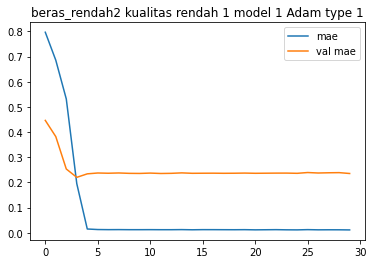

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras_rendah2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
60.000774 0.57774967 68.4518356846166


,actual,prediction
0,10400,10409.885742
1,10400,10409.833984
2,10400,10409.577148
3,10400,10409.625000
4,10400,10409.329102
...,...,...
229,10500,10420.068359
230,10450,10419.947266
231,10450,10419.831055
232,10450,10420.071289


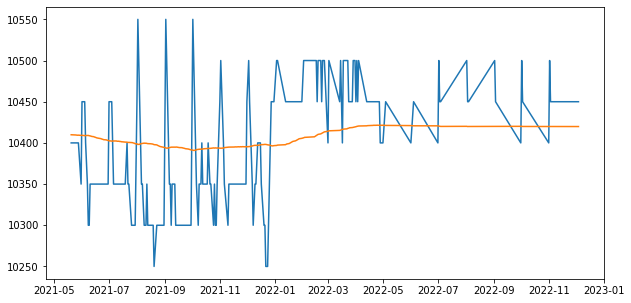

In [ ]:
prediction_a = forecast_predict(model_a, test_beras_rendah2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_rendah2_a = pd.DataFrame()
# data_new_beras_rendah21['date'] = date_test
data_new_beras_rendah2_a['actual'] = x_test
data_new_beras_rendah2_a['prediction'] = data_result_a
data_new_beras_rendah2_a.to_csv('beras_rendah2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_rendah2_a.actual)
plt.plot(y_test, data_new_beras_rendah2_a.prediction)
data_new_beras_rendah2_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0017 - mae: 0.0305 - mape: 4.0446 - val_loss: 0.1048 - val_mae: 0.2504 - val_mape: 75435840.0000
Epoch 2/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0017 - mae: 0.0305 - mape: 4.0402 - val_loss: 0.1084 - val_mae: 0.2567 - val_mape: 76316296.0000
Epoch 3/30
718/718 [==============================] - 28s 38ms/step - loss: 0.0016 - mae: 0.0295 - mape: 3.8981 - val_loss: 0.1133 - val_mae: 0.2651 - val_mape: 77462640.0000
Epoch 4/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0017 - mae: 0.0303 - mape: 4.0240 - val_loss: 0.1118 - val_mae: 0.2628 - val_mape: 77102088.0000
Epoch 5/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0016 - mae: 0.0300 - mape: 3.9774 - val_loss: 0.1141 - val_mae: 0.2665 - val_mape: 77620416.0000
Epoch 6/30
718/718 [==============================] - 26s 37ms/step - loss: 0.0016 - mae: 0.0296 - mape: 3.9218 - val_loss: 0

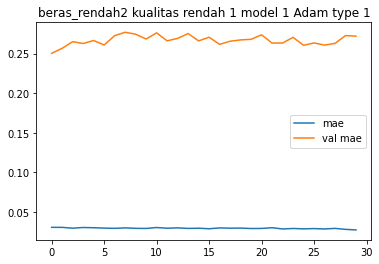

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras_rendah2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
72.27414 0.69836277 88.28392418516097


,actual,prediction
0,10400,10451.674805
1,10400,10453.960938
2,10400,10451.692383
3,10400,10453.695312
4,10400,10451.627930
...,...,...
229,10500,10458.119141
230,10450,10456.893555
231,10450,10459.045898
232,10450,10456.987305


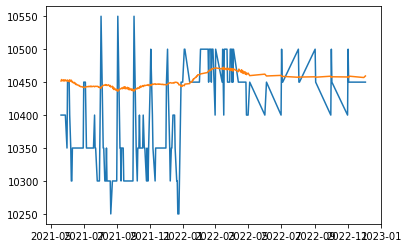

In [ ]:
prediction_a1 = forecast_predict(model_a, test_beras_rendah2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_rendah2_a1 = pd.DataFrame()
data_new_beras_rendah2_a1['actual'] = x_test
data_new_beras_rendah2_a1['prediction'] = data_result_a1
data_new_beras_rendah2_a1.to_csv('beras_rendah2_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_rendah2_a1.actual)
plt.plot(y_test, data_new_beras_rendah2_a1.prediction)
data_new_beras_rendah2_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 15s 137ms/step - loss: 0.4260 - mae: 0.6465 - mape: 86.2347 - val_loss: 0.1129 - val_mae: 0.2976 - val_mape: 26508302.0000
Epoch 2/30
84/84 [==============================] - 11s 124ms/step - loss: 0.0445 - mae: 0.1502 - mape: 20.0009 - val_loss: 0.0812 - val_mae: 0.1993 - val_mape: 68666648.0000
Epoch 3/30
84/84 [==============================] - 11s 124ms/step - loss: 8.4291e-04 - mae: 0.0201 - mape: 2.6874 - val_loss: 0.0777 - val_mae: 0.1901 - val_mape: 67392432.0000
Epoch 4/30
84/84 [==============================] - 10s 123ms/step - loss: 8.3942e-04 - mae: 0.0198 - mape: 2.6404 - val_loss: 0.0787 - val_mae: 0.1929 - val_mape: 67779760.0000
Epoch 5/30
84/84 [==============================] - 12s 142ms/step - loss: 8.3765e-04 - mae: 0.0200 - mape: 2.6605 - val_loss: 0.0803 - val_mae: 0.1970 - val_mape: 68360624.0000
Epoch 6/30
84/84 [==============================] - 11s 124ms/step - loss: 8.5596e-04 - mae: 0.0204 - mape: 2.7259 -

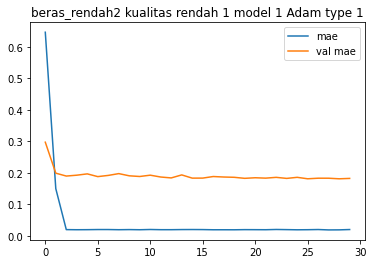

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras_rendah2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 11ms/step
50.071392 0.48117545 61.777084773603555


,actual,prediction
0,10400,10402.614258
1,10400,10401.018555
2,10400,10402.079102
3,10400,10400.433594
4,10400,10401.569336
...,...,...
229,10500,10429.655273
230,10450,10429.108398
231,10450,10429.036133
232,10450,10429.177734


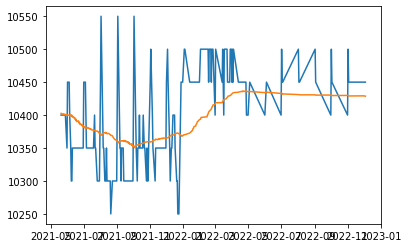

In [ ]:
prediction_a2 = forecast_predict(model_a, test_beras_rendah2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_rendah2_a2 = pd.DataFrame()
# data_new_beras_rendah21['date'] = date_test
data_new_beras_rendah2_a2['actual'] = x_test
data_new_beras_rendah2_a2['prediction'] = data_result_a2
data_new_beras_rendah2_a2.to_csv('beras_rendah2_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_rendah2_a2.actual)
plt.plot(y_test, data_new_beras_rendah2_a2.prediction)
data_new_beras_rendah2_a2

## model 1

### Adam

In [9]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 20s 355ms/step - loss: 0.4583 - mae: 0.6721 - mape: 87.0540 - val_loss: 0.1054 - val_mae: 0.2876 - val_mape: 27789180.0000
Epoch 2/15
44/44 [==============================] - 14s 326ms/step - loss: 0.0280 - mae: 0.1194 - mape: 15.4296 - val_loss: 0.0720 - val_mae: 0.1797 - val_mape: 64638504.0000
Epoch 3/15
44/44 [==============================] - 14s 327ms/step - loss: 3.3668e-04 - mae: 0.0153 - mape: 1.9789 - val_loss: 0.0672 - val_mae: 0.1825 - val_mape: 62295028.0000
Epoch 4/15
44/44 [==============================] - 14s 325ms/step - loss: 2.8769e-04 - mae: 0.0143 - mape: 1.8552 - val_loss: 0.0673 - val_mae: 0.1825 - val_mape: 62318808.0000
Epoch 5/15
44/44 [==============================] - 14s 327ms/step - loss: 2.8249e-04 - mae: 0.0143 - mape: 1.8461 - val_loss: 0.0671 - val_mae: 0.1826 - val_mape: 62213460.0000
Epoch 6/15
44/44 [==============================] - 15s 328ms/step - loss: 3.1481e-04 - mae: 0.0150 - mape: 1.9410 -

17/17 [==============================] - 0s 17ms/step - loss: 0.0246 - mae: 0.1280 - mape: 17.7739


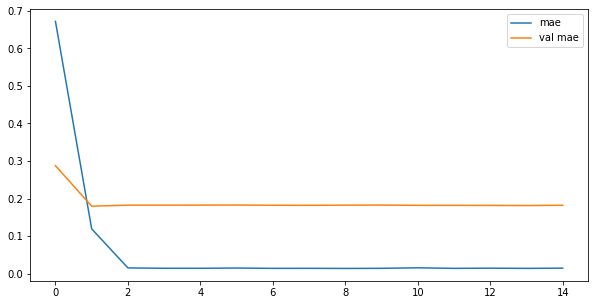

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_beras_rendah2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras_rendah21 = pd.DataFrame()
data_new_beras_rendah21['actual'] = x_test
data_new_beras_rendah21['prediction'] = data_result1
data_new_beras_rendah21.to_csv('beras_rendah2_model2_adam_type1.csv')

data_new_beras_rendah21

131/131 [==============================] - 5s 33ms/step
100.692444 0.97319686 120.07745303162663


,actual,prediction
0,10400,10490.456055
1,10400,10490.539062
2,10400,10490.435547
3,10400,10490.513672
4,10400,10490.403320
...,...,...
229,10500,10491.663086
230,10450,10491.715820
231,10450,10491.691406
232,10450,10491.738281


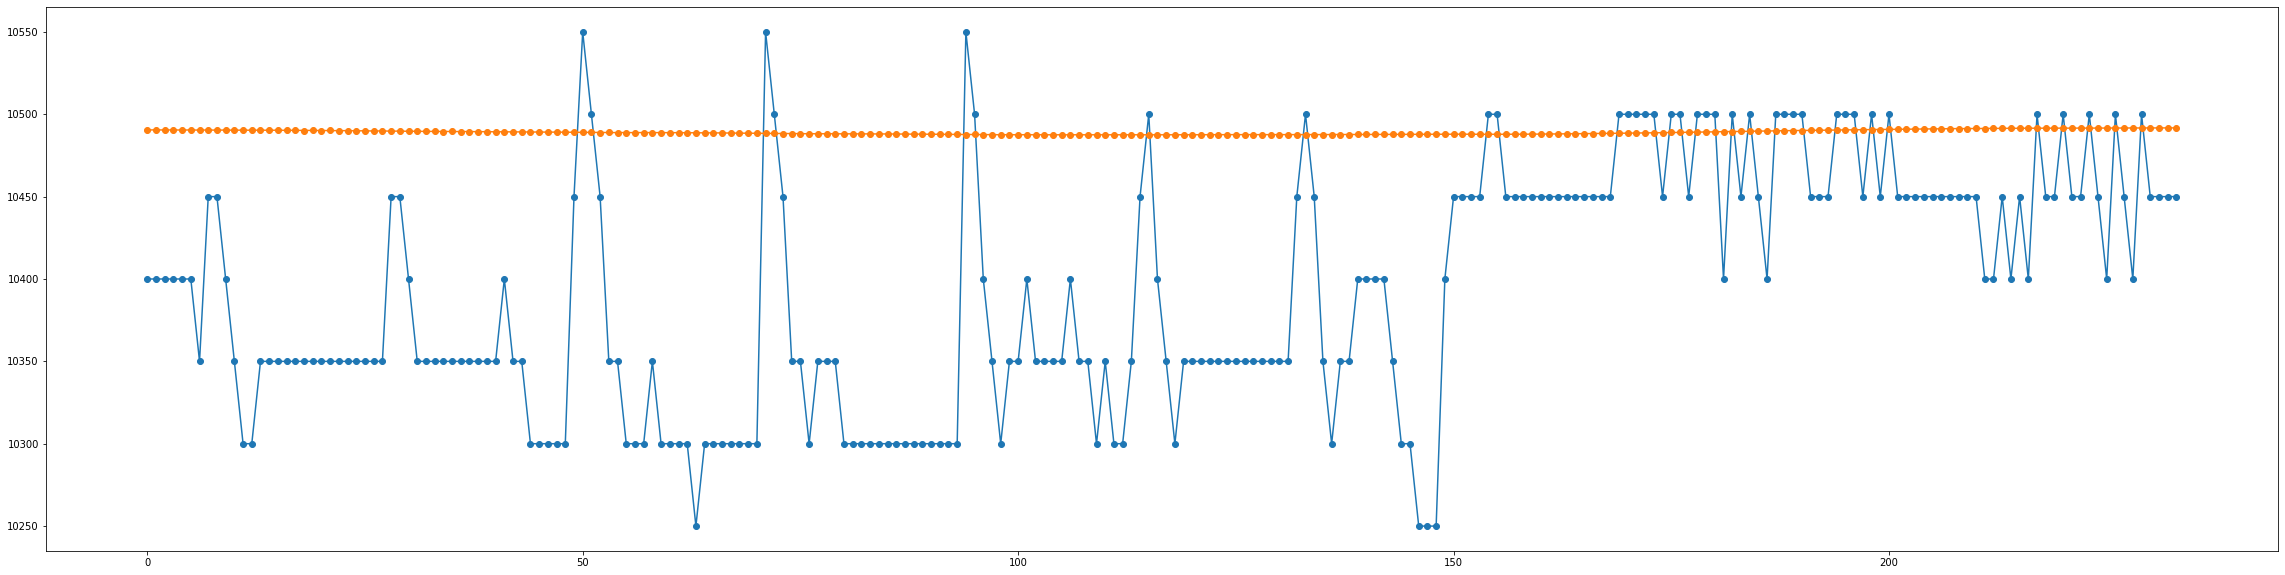

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras_rendah21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras_rendah21['prediction'], '-o')

#### Type 2

In [13]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 34s 42ms/step - loss: 0.0272 - mae: 0.0690 - mape: 9.0835 - val_loss: 0.1250 - val_mae: 0.2846 - val_mape: 79783688.0000
Epoch 2/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0018 - mae: 0.0304 - mape: 4.0367 - val_loss: 0.1119 - val_mae: 0.2638 - val_mape: 76970568.0000
Epoch 3/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0018 - mae: 0.0313 - mape: 4.1509 - val_loss: 0.1247 - val_mae: 0.2841 - val_mape: 79761024.0000
Epoch 4/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0018 - mae: 0.0313 - mape: 4.1587 - val_loss: 0.1190 - val_mae: 0.2752 - val_mape: 78566272.0000
Epoch 5/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0018 - mae: 0.0313 - mape: 4.1480 - val_loss: 0.1149 - val_mae: 0.2687 - val_mape: 77671352.0000
Epoch 6/15
718/718 [==============================] - 29s 40ms/step - loss: 0.0018 - mae: 0.0315 - mape: 4.1782 - val_loss: 0

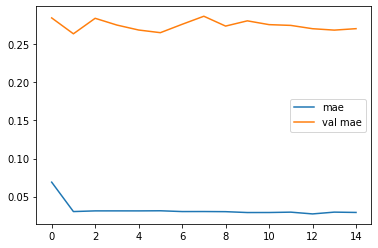

In [14]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
102.4738 0.9901361 120.06051534018168


,actual,prediction
0,10400,10495.776367
1,10400,10495.778320
2,10400,10495.798828
3,10400,10495.844727
4,10400,10496.021484
...,...,...
229,10500,10503.213867
230,10450,10503.207031
231,10450,10503.432617
232,10450,10503.123047


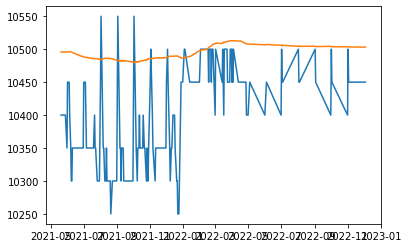

In [15]:
prediction1_1 = forecast_predict(model1, test_beras_rendah2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras_rendah21_1 = pd.DataFrame()
data_new_beras_rendah21_1['actual'] = x_test
data_new_beras_rendah21_1['prediction'] = data_result1_1
data_new_beras_rendah21_1.to_csv('beras_rendah2_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras_rendah21_1.actual)
plt.plot(y_test, data_new_beras_rendah21_1.prediction)
data_new_beras_rendah21_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 26s 260ms/step - loss: 0.2180 - mae: 0.3674 - mape: 48.7894 - val_loss: 0.0750 - val_mae: 0.1845 - val_mape: 66096628.0000
Epoch 2/15
84/84 [==============================] - 20s 231ms/step - loss: 0.0011 - mae: 0.0241 - mape: 3.2237 - val_loss: 0.0673 - val_mae: 0.1820 - val_mape: 62466912.0000
Epoch 3/15
84/84 [==============================] - 18s 211ms/step - loss: 9.0696e-04 - mae: 0.0217 - mape: 2.8935 - val_loss: 0.0699 - val_mae: 0.1804 - val_mape: 63843952.0000
Epoch 4/15
84/84 [==============================] - 17s 200ms/step - loss: 9.1061e-04 - mae: 0.0212 - mape: 2.8266 - val_loss: 0.0696 - val_mae: 0.1806 - val_mape: 63683916.0000
Epoch 5/15
84/84 [==============================] - 17s 202ms/step - loss: 9.3434e-04 - mae: 0.0217 - mape: 2.8904 - val_loss: 0.0688 - val_mae: 0.1811 - val_mape: 63289716.0000
Epoch 6/15
84/84 [==============================] - 18s 214ms/step - loss: 8.9052e-04 - mae: 0.0209 - mape: 2.7935 - 

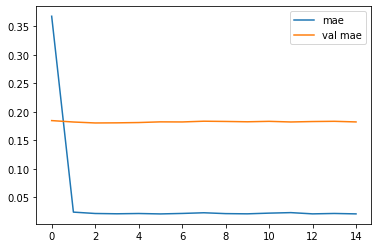

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 5s 30ms/step
61.89187 0.59690046 71.91285687813411


,actual,prediction
0,10400,10446.082031
1,10400,10445.584961
2,10400,10445.508789
3,10400,10445.005859
4,10400,10445.048828
...,...,...
229,10500,10470.226562
230,10450,10470.984375
231,10450,10469.981445
232,10450,10470.743164


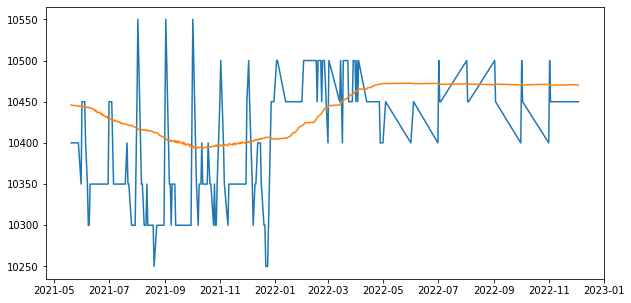

In [ ]:
prediction1_2 = forecast_predict(model1, test_beras_rendah2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras_rendah21_2 = pd.DataFrame()
data_new_beras_rendah21_2['actual'] = x_test
data_new_beras_rendah21_2['prediction'] = data_result1_2
data_new_beras_rendah21_2.to_csv('beras_rendah2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah21_2.actual)
plt.plot(y_test, data_new_beras_rendah21_2.prediction)

data_new_beras_rendah21_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 25s 376ms/step - loss: 0.5674 - mae: 0.7518 - mape: 97.4114 - val_loss: 0.2056 - val_mae: 0.4050 - val_mape: 9742391.0000
Epoch 2/15
44/44 [==============================] - 14s 319ms/step - loss: 0.3996 - mae: 0.6311 - mape: 81.7668 - val_loss: 0.1409 - val_mae: 0.3299 - val_mape: 20173458.0000
Epoch 3/15
44/44 [==============================] - 14s 321ms/step - loss: 0.2900 - mae: 0.5377 - mape: 69.6591 - val_loss: 0.0999 - val_mae: 0.2802 - val_mape: 29139086.0000
Epoch 4/15
44/44 [==============================] - 15s 342ms/step - loss: 0.2098 - mae: 0.4572 - mape: 59.2254 - val_loss: 0.0748 - val_mae: 0.2381 - val_mape: 37165632.0000
Epoch 5/15
44/44 [==============================] - 14s 324ms/step - loss: 0.1499 - mae: 0.3864 - mape: 50.0545 - val_loss: 0.0617 - val_mae: 0.2046 - val_mape: 44236268.0000
Epoch 6/15
44/44 [==============================] - 14s 326ms/step - loss: 0.1056 - mae: 0.3240 - mape: 41.9646 - val_loss: 0.

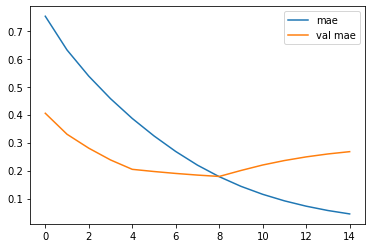

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 33ms/step
78.10158 0.747916 97.02012315429722


,actual,prediction
0,10400,10328.683594
1,10400,10328.946289
2,10400,10328.562500
3,10400,10328.740234
4,10400,10328.380859
...,...,...
229,10500,10331.377930
230,10450,10331.352539
231,10450,10331.408203
232,10450,10331.329102


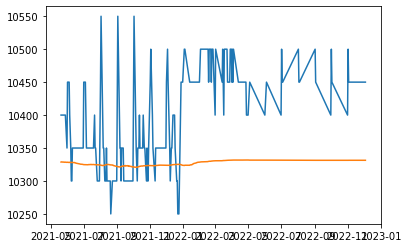

In [ ]:
prediction1_a = forecast_predict(model1_a, test_beras_rendah2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras_rendah21_a = pd.DataFrame()
data_new_beras_rendah21_a['actual'] = x_test
data_new_beras_rendah21_a['prediction'] = data_result1_a
data_new_beras_rendah21_a.to_csv('beras_rendah2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras_rendah21_a.actual)
plt.plot(y_test, data_new_beras_rendah21_a.prediction)

data_new_beras_rendah21_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0016 - mae: 0.0303 - mape: 3.9864 - val_loss: 0.1270 - val_mae: 0.2878 - val_mape: 80134720.0000
Epoch 2/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0016 - mae: 0.0313 - mape: 4.1613 - val_loss: 0.1283 - val_mae: 0.2898 - val_mape: 80418176.0000
Epoch 3/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0016 - mae: 0.0319 - mape: 4.2407 - val_loss: 0.1278 - val_mae: 0.2890 - val_mape: 80307888.0000
Epoch 4/15
718/718 [==============================] - 31s 42ms/step - loss: 0.0016 - mae: 0.0317 - mape: 4.2146 - val_loss: 0.1280 - val_mae: 0.2892 - val_mape: 80347232.0000
Epoch 5/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0016 - mae: 0.0315 - mape: 4.1954 - val_loss: 0.1277 - val_mae: 0.2889 - val_mape: 80300696.0000
Epoch 6/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0016 - mae: 0.0318 - mape: 4.2306 - val_loss: 0

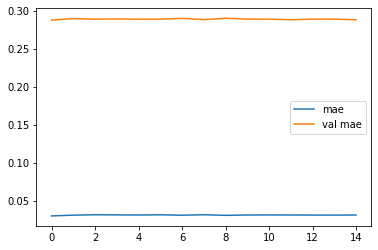

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
61.310295 0.58966666 69.8800555807503


,actual,prediction
0,10400,10393.830078
1,10400,10394.148438
2,10400,10393.669922
3,10400,10393.902344
4,10400,10393.464844
...,...,...
229,10500,10398.152344
230,10450,10397.761719
231,10450,10398.272461
232,10450,10397.780273


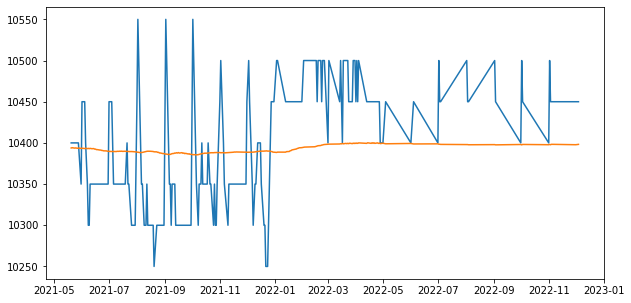

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_beras_rendah2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras_rendah21_a1 = pd.DataFrame()
data_new_beras_rendah21_a1['actual'] = x_test
data_new_beras_rendah21_a1['prediction'] = data_result1_a1
data_new_beras_rendah21_a1.to_csv('beras_rendah2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah21_a1.actual)
plt.plot(y_test, data_new_beras_rendah21_a1.prediction)
data_new_beras_rendah21_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_beras_rendah2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras_rendah21_a2 = pd.DataFrame()
data_new_beras_rendah21_a2['actual'] = x_test
data_new_beras_rendah21_a2['prediction'] = data_result1_a2
data_new_beras_rendah21_a2.to_csv('beras_rendah2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah21_a2.actual)
plt.plot(y_test, data_new_beras_rendah21_a2.prediction)

data_new_beras_rendah21_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 135ms/step - loss: 0.5233 - mae: 0.7225 - mape: 93.6103 - val_loss: 0.1910 - val_mae: 0.3898 - val_mape: 11831703.0000
Epoch 2/50
44/44 [==============================] - 5s 113ms/step - loss: 0.3687 - mae: 0.6060 - mape: 78.5134 - val_loss: 0.1205 - val_mae: 0.3055 - val_mape: 24166054.0000
Epoch 3/50
44/44 [==============================] - 5s 113ms/step - loss: 0.2501 - mae: 0.4990 - mape: 64.6466 - val_loss: 0.0806 - val_mae: 0.2498 - val_mape: 34778456.0000
Epoch 4/50
44/44 [==============================] - 6s 129ms/step - loss: 0.1674 - mae: 0.4081 - mape: 52.8575 - val_loss: 0.0619 - val_mae: 0.2046 - val_mape: 43792728.0000
Epoch 5/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1103 - mae: 0.3309 - mape: 42.8563 - val_loss: 0.0570 - val_mae: 0.1951 - val_mape: 51398516.0000
Epoch 6/50
44/44 [==============================] - 5s 114ms/step - loss: 0.0715 - mae: 0.2664 - mape: 34.4926 - val_loss: 0.0604

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

In [ ]:
prediction2 = forecast_predict(model2, test_beras_rendah2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras_rendah22 = pd.DataFrame()
data_new_beras_rendah22['actual'] = x_test
data_new_beras_rendah22['prediction'] = data_result2
data_new_beras_rendah22.to_csv('beras_rendah2_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah22.actual)
plt.plot(y_test, data_new_beras_rendah22.prediction)
data_new_beras_rendah22

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0017 - mae: 0.0336 - mape: 4.4941 - val_loss: 0.1350 - val_mae: 0.2999 - val_mape: 81621424.0000
Epoch 2/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0016 - mae: 0.0326 - mape: 4.3407 - val_loss: 0.1359 - val_mae: 0.3012 - val_mape: 81797120.0000
Epoch 3/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0016 - mae: 0.0325 - mape: 4.3329 - val_loss: 0.1363 - val_mae: 0.3016 - val_mape: 81861096.0000
Epoch 4/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0017 - mae: 0.0328 - mape: 4.3712 - val_loss: 0.1365 - val_mae: 0.3020 - val_mape: 81907208.0000
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0016 - mae: 0.0325 - mape: 4.3261 - val_loss: 0.1361 - val_mae: 0.3014 - val_mape: 81831480.0000
Epoch 6/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0017 - mae: 0.0330 - mape: 4.3933 - val_loss: 0

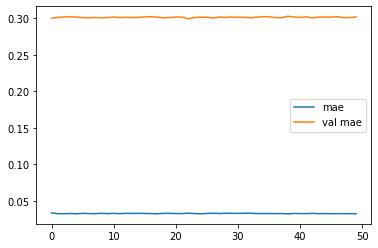

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_beras_rendah2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras_rendah22_1 = pd.DataFrame()
data_new_beras_rendah22_1['actual'] = x_test
data_new_beras_rendah22_1['prediction'] = data_result2_1
data_new_beras_rendah22_1.to_csv('beras_rendah2_model3_sgd_type2.csv')

data_new_beras_rendah22

199/199 [==============================] - 1s 5ms/step
63.909935 0.61425406 72.51117572808174


,actual,prediction
0,10400,10430.312500
1,10400,10430.096680
2,10400,10430.250000
3,10400,10430.012695
4,10400,10430.306641
...,...,...
229,10500,10431.545898
230,10450,10431.227539
231,10450,10431.519531
232,10450,10431.170898


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0013 - mae: 0.0273 - mape: 3.6905 - val_loss: 0.1346 - val_mae: 0.2993 - val_mape: 81547432.0000
Epoch 2/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0013 - mae: 0.0274 - mape: 3.6976 - val_loss: 0.1333 - val_mae: 0.2974 - val_mape: 81287760.0000
Epoch 3/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0012 - mae: 0.0273 - mape: 3.6796 - val_loss: 0.1323 - val_mae: 0.2960 - val_mape: 81098456.0000
Epoch 4/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0013 - mae: 0.0278 - mape: 3.7325 - val_loss: 0.1318 - val_mae: 0.2953 - val_mape: 81002080.0000
Epoch 5/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0013 - mae: 0.0280 - mape: 3.7487 - val_loss: 0.1315 - val_mae: 0.2949 - val_mape: 80941696.0000
Epoch 6/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0013 - mae: 0.0282 - mape: 3.7907 - val_loss: 0.1313 - val_mae: 0

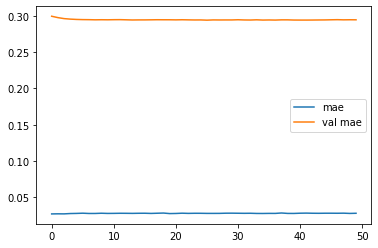

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_beras_rendah2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras_rendah22_2 = pd.DataFrame()
data_new_beras_rendah22_2['actual'] = x_test
data_new_beras_rendah22_2['prediction'] = data_result2_2
data_new_beras_rendah22_2.to_csv('beras_rendah2_model3_sgd-type3.csv')

data_new_beras_rendah22_2

181/181 [==============================] - 2s 8ms/step
64.173454 0.61620617 74.2899329695821


,actual,prediction
0,10400,10375.123047
1,10400,10374.521484
2,10400,10375.166016
3,10400,10374.557617
4,10400,10375.108398
...,...,...
229,10500,10375.955078
230,10450,10375.518555
231,10450,10375.985352
232,10450,10375.583008


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 11s 149ms/step - loss: 0.4355 - mae: 0.6551 - mape: 84.8619 - val_loss: 0.1174 - val_mae: 0.3021 - val_mape: 24962802.0000
Epoch 2/50
44/44 [==============================] - 6s 126ms/step - loss: 0.0480 - mae: 0.1629 - mape: 21.0368 - val_loss: 0.0578 - val_mae: 0.1975 - val_mape: 50685304.0000
Epoch 3/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0015 - mae: 0.0309 - mape: 4.0025 - val_loss: 0.0580 - val_mae: 0.1945 - val_mape: 53223000.0000
Epoch 4/50
44/44 [==============================] - 6s 126ms/step - loss: 8.3613e-04 - mae: 0.0234 - mape: 3.0358 - val_loss: 0.0580 - val_mae: 0.1946 - val_mape: 53205152.0000
Epoch 5/50
44/44 [==============================] - 6s 127ms/step - loss: 7.3441e-04 - mae: 0.0220 - mape: 2.8530 - val_loss: 0.0580 - val_mae: 0.1947 - val_mape: 53107464.0000
Epoch 6/50
44/44 [==============================] - 6s 125ms/step - loss: 6.7655e-04 - mae: 0.0212 - mape: 2.7453 - val_loss

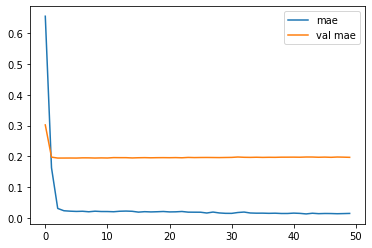

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_beras_rendah2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras_rendah22_a = pd.DataFrame()
data_new_beras_rendah22_a['actual'] = x_test
data_new_beras_rendah22_a['prediction'] = data_result2_a
data_new_beras_rendah22_a.to_csv('beras_rendah2_model3_adam-type1.csv')

data_new_beras_rendah22_a

131/131 [==============================] - 4s 18ms/step
72.79762 0.7033529 89.56609542242394


,actual,prediction
0,10400,10451.120117
1,10400,10451.401367
2,10400,10451.232422
3,10400,10451.326172
4,10400,10450.867188
...,...,...
229,10500,10454.281250
230,10450,10454.242188
231,10450,10454.555664
232,10450,10455.053711


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 18s 24ms/step - loss: 0.0028 - mae: 0.0371 - mape: 4.9039 - val_loss: 0.0916 - val_mae: 0.2259 - val_mape: 71505080.0000
Epoch 2/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0021 - mae: 0.0333 - mape: 4.4214 - val_loss: 0.1021 - val_mae: 0.2469 - val_mape: 74400376.0000
Epoch 3/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0018 - mae: 0.0320 - mape: 4.2449 - val_loss: 0.1108 - val_mae: 0.2623 - val_mape: 76526400.0000
Epoch 4/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0017 - mae: 0.0308 - mape: 4.0926 - val_loss: 0.1202 - val_mae: 0.2777 - val_mape: 78638680.0000
Epoch 5/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0019 - mae: 0.0327 - mape: 4.3466 - val_loss: 0.1308 - val_mae: 0.2937 - val_mape: 80846392.0000
Epoch 6/50
718/718 [==============================] - 17s 24ms/step - loss: 0.0017 - mae: 0.0313 - mape: 4.1507 - val_loss: 0

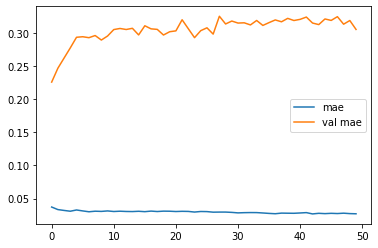

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
137.14377 1.3239007 151.53748504907952


,actual,prediction
0,10400,10532.930664
1,10400,10532.149414
2,10400,10531.543945
3,10400,10532.743164
4,10400,10533.212891
...,...,...
229,10500,10552.616211
230,10450,10550.703125
231,10450,10552.297852
232,10450,10550.117188


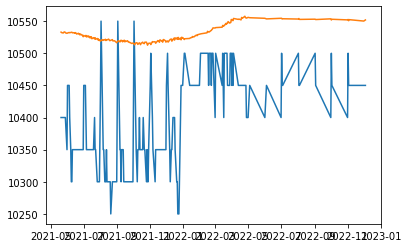

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_beras_rendah2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras_rendah22_a1 = pd.DataFrame()
data_new_beras_rendah22_a1['actual'] = x_test
data_new_beras_rendah22_a1['prediction'] = data_result2_a1
data_new_beras_rendah22_a1.to_csv('beras_rendah2_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras_rendah22_a1.actual)
plt.plot(y_test, data_new_beras_rendah22_a1.prediction)
data_new_beras_rendah22_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 11s 133ms/step - loss: 7.5745e-04 - mae: 0.0178 - mape: 2.3596 - val_loss: 0.1407 - val_mae: 0.3083 - val_mape: 82801456.0000
Epoch 2/50
84/84 [==============================] - 7s 87ms/step - loss: 7.2430e-04 - mae: 0.0167 - mape: 2.2121 - val_loss: 0.1431 - val_mae: 0.3115 - val_mape: 83257184.0000
Epoch 3/50
84/84 [==============================] - 7s 86ms/step - loss: 6.9185e-04 - mae: 0.0167 - mape: 2.2093 - val_loss: 0.1342 - val_mae: 0.2993 - val_mape: 81659824.0000
Epoch 4/50
84/84 [==============================] - 7s 85ms/step - loss: 7.5923e-04 - mae: 0.0176 - mape: 2.3309 - val_loss: 0.1376 - val_mae: 0.3041 - val_mape: 82220240.0000
Epoch 5/50
84/84 [==============================] - 7s 86ms/step - loss: 7.5905e-04 - mae: 0.0171 - mape: 2.2639 - val_loss: 0.1455 - val_mae: 0.3147 - val_mape: 83705168.0000
Epoch 6/50
84/84 [==============================] - 8s 92ms/step - loss: 7.2946e-04 - mae: 0.0170 - mape: 2.2442 - val

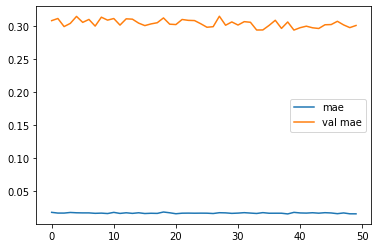

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 9ms/step
113.43025 1.0876138 128.3544439481937


,actual,prediction
0,10400,10268.245117
1,10400,10267.166016
2,10400,10270.763672
3,10400,10266.442383
4,10400,10268.758789
...,...,...
229,10500,10320.018555
230,10450,10320.606445
231,10450,10318.906250
232,10450,10321.319336


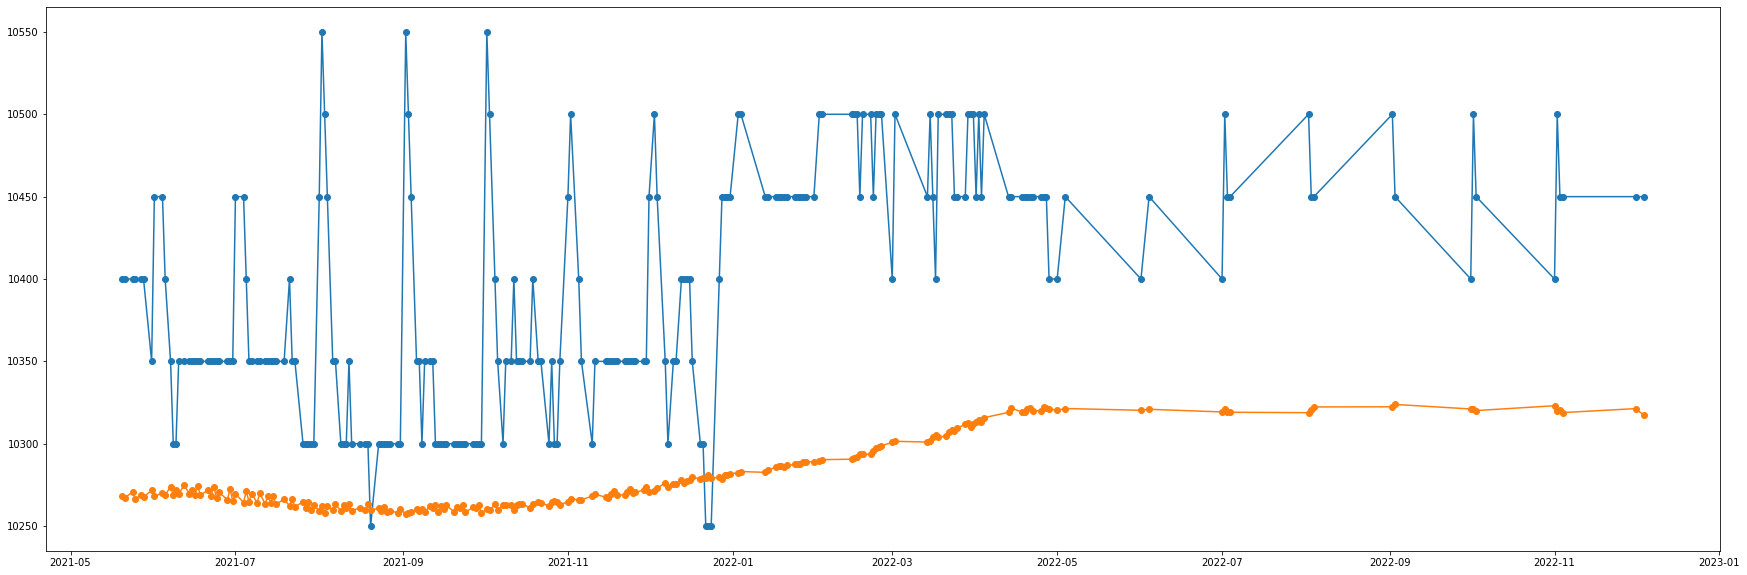

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_beras_rendah2_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras_rendah22_a2 = pd.DataFrame()
data_new_beras_rendah22_a2['actual'] = x_test
data_new_beras_rendah22_a2['prediction'] = data_result2_a2
data_new_beras_rendah22_a2.to_csv('beras_rendah2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras_rendah22_a2.actual, '-o')
plt.plot(y_test,data_new_beras_rendah22_a2.prediction, '-o')
data_new_beras_rendah22_a2